In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow_hub as hub
import tensorflow as tf
from bert_tokenization import bertTokenization as tokenization
import tensorflow.keras.backend as K
import gc
import os
from scipy.stats import spearmanr
from math import floor, ceil
import seaborn as sns

np.set_printoptions(suppress=True)

**lable selected for our project:** 
answer_relevance prediction

In [36]:
PATH = 'input/Data/'
BERT_PATH = 'input/bert-base-from-tfhub/bert_en_uncased_L-12_H-768_A-12'
tokenizer = tokenization.FullTokenizer(BERT_PATH+'/assets/vocab.txt', True)
MAX_SEQUENCE_LENGTH = 512

df_train = pd.read_csv(PATH+'train.csv')
df_test = pd.read_csv(PATH+'test.csv')
df_sub = pd.read_csv(PATH+'sample_submission.csv')

##remove later!!!
df_train = df_train[:4]
df_test = df_test[:4]
df_sub = df_sub[:4]

print('train shape =', df_train.shape)
print('test shape =', df_test.shape)

train shape = (4, 41)
test shape = (4, 11)


**DATA engineering:**


1.NaN handling

In [37]:
count = 0
for var in df_train.head(1):
    for elem in df_train[var]:
        if elem == 'NaN' :
            count +=1    
    print(var , count/df_train.shape[0])
    count = 0


qa_id 0.0
question_title 0.0
question_body 0.0
question_user_name 0.0
question_user_page 0.0
answer 0.0
answer_user_name 0.0
answer_user_page 0.0
url 0.0
category 0.0
host 0.0
question_asker_intent_understanding 0.0
question_body_critical 0.0
question_conversational 0.0
question_expect_short_answer 0.0
question_fact_seeking 0.0
question_has_commonly_accepted_answer 0.0
question_interestingness_others 0.0
question_interestingness_self 0.0
question_multi_intent 0.0
question_not_really_a_question 0.0
question_opinion_seeking 0.0
question_type_choice 0.0
question_type_compare 0.0
question_type_consequence 0.0
question_type_definition 0.0
question_type_entity 0.0
question_type_instructions 0.0
question_type_procedure 0.0
question_type_reason_explanation 0.0
question_type_spelling 0.0
question_well_written 0.0
answer_helpful 0.0
answer_level_of_information 0.0
answer_plausible 0.0
answer_relevance 0.0
answer_satisfaction 0.0
answer_type_instructions 0.0
answer_type_procedure 0.0
answer_type_

2.Extraction of 'host' and 'category' to 'sub_category'

C:\Users\elirane\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


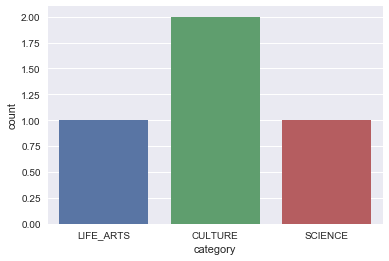

In [38]:
%matplotlib inline
sns.countplot(x='category', data=df_train)

In [39]:
df_train['host']=df_train['host'].apply(lambda x:(x.replace(x ,x.split('.')[0])))
df_test['host']=df_test['host'].apply(lambda x:(x.replace(x ,x.split('.')[0])))

In [40]:
df_train.columns = df_train.columns.str.replace('host', 'sub_category')
df_test.columns = df_test.columns.str.replace('host', 'sub_category')

In [41]:
#we trying to figure out if category is redundent due to the sub category
arr_sub_category = {}
for sub in df_train['sub_category'].unique():
    data = df_train[df_train['sub_category'] == sub]
    arr = df_train[df_train['sub_category'] == sub]['category'].unique()
    if len(arr) > 1:
        arr_sub_category[sub] = arr
        print(sub, arr)
        #correlation between two features

In [42]:
# split each sub_category found to be multiplied to more than one category 
#(in order to drop the category feature without loosing any important info)
for key in arr_sub_category.keys():
    for val in arr_sub_category[key]:
        df_train[(df_train['sub_category'] == key) & (df_train['category'] == val)] = df_train[(df_train['sub_category'] == key) & (df_train['category'] == val)].apply(lambda x :x.replace(key, key+'_'+val))


In [43]:
# checking
print(df_train['sub_category'].unique())

['photo' 'rpg' 'electronics' 'judaism']


3.features plots

C:\Users\elirane\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


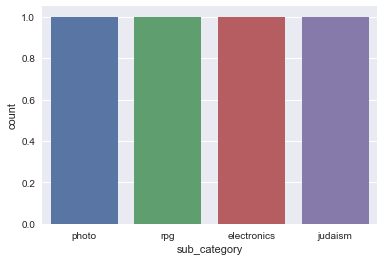

In [44]:
%matplotlib inline
sns.countplot(x='sub_category', data=df_train)

4.correlation sorted list between features

In [45]:
 def corrank(X):## to think about relevant correlations (sub_c and lable?, is text coor is relevant?)
        import itertools
        dff = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(method = 'spearman'), 2))],columns=['pairs','corr'])    
        print(dff.sort_values(by='corr',ascending=False))

In [46]:
corrank(df_train)

                                                 pairs      corr
230  (question_interestingness_self, answer_type_in...  1.000000
140  (question_fact_seeking, question_has_commonly_...  1.000000
313  (question_type_compare, question_type_definition)  1.000000
396   (question_type_procedure, answer_type_procedure)  1.000000
458         (answer_satisfaction, answer_well_written)  1.000000
192  (question_interestingness_others, question_opi...  0.997509
138  (question_expect_short_answer, answer_type_rea...  0.984732
380     (question_type_instructions, answer_plausible)  0.962250
420            (question_well_written, answer_helpful)  0.956183
3                (qa_id, question_expect_short_answer)  0.943880
214  (question_interestingness_self, question_opini...  0.942809
163  (question_fact_seeking, answer_type_reason_exp...  0.942809
290  (question_opinion_seeking, answer_type_instruc...  0.942809
187  (question_has_commonly_accepted_answer, answer...  0.942809
189  (question_interestin

**5.tokenization?**

6.**Categorizing questions**
#HowTo - instructions (looking for actions in the answer)
#Why 
#What / which kind of - classification
#what is better - comparison
#when / how often - time
#what/ how many/ how much - quantative
#where - places
#who / whom - person
#how does / how are - comprehension
#can/ could - capability
#should /would you/ do you want / is, are, am / does- Yes/No questions, willing
#aren't you? wasn't it? - tag questions (in YES/NO)

In [47]:
data_a = np.array([['Can an affidavit be used in Beit Din?', 10], ['How can I write HTML and send as an email?', 15], ['How do I remove a Facebook app request?', 14], ['How do you grapple in Dead Rising 3?', 1], ['How do you make a binary image in Photoshop?', 1]]) 
df_a = pd.DataFrame(data_a)
df_a.columns = ["question", "num"]
print(df_a)

from adam_qas import adam_script as adam
dfOut = pd.DataFrame(np.array([["","",""]]))
dfOut.columns = ["q_class","q_keywords","quary"]
dfOut = dfOut[:-1]
new_features = adam.activate(df_a['question'], dfOut)
print(new_features.head(2))
df_a.join(new_features)
print(df_a.head(5))

                                       question num
0         Can an affidavit be used in Beit Din?  10
1    How can I write HTML and send as an email?  15
2       How do I remove a Facebook app request?  14
3          How do you grapple in Dead Rising 3?   1
4  How do you make a binary image in Photoshop?   1


DEBUG:adam_qas.adam_script:WH :  | WH-POS :  | WH-NBOR-POS :  | Root-POS : VBN
DEBUG:adam_qas.adam_script:Union Columns: 66
DEBUG:adam_qas.adam_script:Training data: (5365, 66)
DEBUG:adam_qas.adam_script:Target data: (1, 66)
DEBUG:adam_qas.adam_script:Classifier: ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']
INFO:__main__:Question Class: ['HUM']
DEBUG:qas.feature_extractor:Compound Noun:affidavit DEP nsubjpass
DEBUG:qas.feature_extractor:Compound Noun:Din DEP pobj
INFO:__main__:Question Features: ['affidavit', 'Beit Din', 'use']
INFO:__main__:Query: [{Features: ['affidavit', 'Beit Din', 'use'] ,Conjunction: [] ,Negations: [] ,Marker: []}]
DEBUG:adam_qas.adam_script:WH : How | WH-POS : WRB | WH-NBOR-POS : MD | Root-POS : VB
DEBUG:adam_qas.adam_script:Union Columns: 63
DEBUG:adam_qas.adam_script:Training data: (5365, 63)
DEBUG:adam_qas.adam_script:Target data: (1, 63)
DEBUG:adam_qas.adam_script:Classifier: ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']
INFO:__main__:Question Class: ['DESC']
DEBUG:q

  q_class              q_keywords  \
0   [HUM]  affidavit,Beit Din,use   
1  [DESC]        HTML,email,write   

                                               quary  
0  [{Features: ['affidavit', 'Beit Din', 'use'] ,...  
1  [{Features: ['HTML', 'email', 'write'] ,Conjun...  
                                       question num
0         Can an affidavit be used in Beit Din?  10
1    How can I write HTML and send as an email?  15
2       How do I remove a Facebook app request?  14
3          How do you grapple in Dead Rising 3?   1
4  How do you make a binary image in Photoshop?   1


                                       question num
0         Can an affidavit be used in Beit Din?  10
1    How can I write HTML and send as an email?  15
2       How do I remove a Facebook app request?  14
3          How do you grapple in Dead Rising 3?   1
4  How do you make a binary image in Photoshop?   1


#### Calling adam's algorithem to produce new features 

In [51]:
from adam_qas import adam_script as adam
dfOut = pd.DataFrame(np.array([["","",""]]))
dfOut.columns = ["q_class","q_keywords","quary"]
dfOut = dfOut[:-1]

new_features = adam.activate(df_train['question_title'], dfOut)
print(new_features)

df_new_train=pd.concat([df_train,new_features], axis=1, sort=False)

print(df_new_train)

DEBUG:adam_qas.adam_script:WH : when | WH-POS : WRB | WH-NBOR-POS : VBG | Root-POS : VBG
DEBUG:adam_qas.adam_script:Union Columns: 63
DEBUG:adam_qas.adam_script:Training data: (5365, 63)
DEBUG:adam_qas.adam_script:Target data: (1, 63)
DEBUG:adam_qas.adam_script:Classifier: ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']
INFO:__main__:Question Class: ['DESC']
DEBUG:qas.feature_extractor:Compound Noun:tubes DEP dobj
DEBUG:qas.feature_extractor:Compound Noun:lens DEP conj
INFO:__main__:Question Features: ['extension tubes', 'lens', 'lose']
DEBUG:qas.query_const:Conjunction: `of` at 9
DEBUG:qas.query_const:Conjuncting: ['tubes', 'lens']
INFO:__main__:Query: [{Features: ['extension tubes', 'lens', 'lose'] ,Conjunction: [['tubes', 'lens'], 'of'] ,Negations: [] ,Marker: []}]
DEBUG:adam_qas.adam_script:WH : What | WH-POS : WP | WH-NBOR-POS : VBZ | Root-POS : VBZ
DEBUG:adam_qas.adam_script:Union Columns: 63
DEBUG:adam_qas.adam_script:Training data: (5365, 63)
DEBUG:adam_qas.adam_script:Target data: (1

  q_class                                         q_keywords  \
0  [DESC]                          extension tubes,lens,lose   
1  [DESC]  distinction,city,sprawl,metroplex,downtown,dis...   
2   [HUM]  protusion length,hole component,component pins...   
3   [HUM]                             affidavit,Beit Din,use   

                                               quary  
0  [{Features: ['extension tubes', 'lens', 'lose'...  
1  [{Features: ['distinction', 'city', 'sprawl', ...  
2  [{Features: ['protusion length', 'hole compone...  
3  [{Features: ['affidavit', 'Beit Din', 'use'] ,...  
   qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   
2      2  Maximum protusion length for through-hole comp...   
3      3              Can an affidavit be used in Beit Din?   

                                       question_body question_user_name  \
0  After play

In [58]:
df_new_train.to_csv(PATH+'df_new_train.csv', index=False)

?.Redefine the features passed to the input categories - add sub_categoty

In [63]:
df_train = pd.read_csv(PATH+'df_new_train.csv')
output_categories = list(df_train.columns[11:41])
# input_categories = list(df_train.columns[[1,2,5]])#orogional code
input_categories = list(df_train.columns[[1,2,5,10,41,42,43]]) # we added the sub_categoty!
print('\noutput categories:\n\t', output_categories)
print('\ninput categories:\n\t', input_categories)


output categories:
	 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']

input categories:
	 ['question_title', 'question_body', 'answer', 'sub_category', 'q_class', 'q_keywords', 'quary']


In [ ]:
def _get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    first_sep = True
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            if first_sep:
                first_sep = False 
            else:
                current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def _get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def _trim_input(title, question, answer, max_sequence_length, 
                t_max_len=30, q_max_len=239, a_max_len=239):

    t = tokenizer.tokenize(title)
    q = tokenizer.tokenize(question)
    a = tokenizer.tokenize(answer)
    
    t_len = len(t)
    q_len = len(q)
    a_len = len(a)

    if (t_len+q_len+a_len+4) > max_sequence_length:
        
        if t_max_len > t_len:
            t_new_len = t_len
            a_max_len = a_max_len + floor((t_max_len - t_len)/2)
            q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        else:
            t_new_len = t_max_len
      
        if a_max_len > a_len:
            a_new_len = a_len 
            q_new_len = q_max_len + (a_max_len - a_len)
        elif q_max_len > q_len:
            a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
            a_new_len = a_max_len
            q_new_len = q_max_len
            
            
        if t_new_len+a_new_len+q_new_len+4 != max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length, (t_new_len+a_new_len+q_new_len+4)))
        
        t = t[:t_new_len]
        q = q[:q_new_len]
        a = a[:a_new_len]
    
    return t, q, a

def _convert_to_bert_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for BERT"""
    
    stoken = ["[CLS]"] + title + ["[SEP]"] + question + ["[SEP]"] + answer + ["[SEP]"]

    input_ids = _get_ids(stoken, tokenizer, max_sequence_length)
    input_masks = _get_masks(stoken, max_sequence_length)
    input_segments = _get_segments(stoken, max_sequence_length)

    return [input_ids, input_masks, input_segments]

def compute_input_arays(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for _, instance in tqdm(df[columns].iterrows()):
        t, q, a = instance.question_title, instance.question_body, instance.answer

        t, q, a = _trim_input(t, q, a, max_sequence_length)

        ids, masks, segments = _convert_to_bert_inputs(t, q, a, tokenizer, max_sequence_length)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]


def compute_output_arrays(df, columns):
    return np.asarray(df[columns])


In [ ]:
def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
    return np.mean(rhos)


class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_data, test_data, batch_size=16, fold=None):

        self.valid_inputs = valid_data[0]
        self.valid_outputs = valid_data[1]
        self.test_inputs = test_data
        
        self.batch_size = batch_size
        self.fold = fold
        
    def on_train_begin(self, logs={}):
        self.valid_predictions = []
        self.test_predictions = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.valid_predictions.append(
            self.model.predict(self.valid_inputs, batch_size=self.batch_size))
        
        rho_val = compute_spearmanr(
            self.valid_outputs, np.average(self.valid_predictions, axis=0))
        
        print("\nvalidation rho: %.4f" % rho_val)
        
        if self.fold is not None:
            self.model.save_weights(f'bert-base-{fold}-{epoch}.h5py')
        
        self.test_predictions.append(
            self.model.predict(self.test_inputs, batch_size=self.batch_size)
        )

def bert_model():
    
    input_word_ids = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
    input_masks = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
    input_segments = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')
    
    bert_layer = hub.KerasLayer(BERT_PATH, trainable=True)
    
    _, sequence_output = bert_layer([input_word_ids, input_masks, input_segments])
    
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(30, activation="sigmoid", name="dense_output")(x)

    model = tf.keras.models.Model(
        inputs=[input_word_ids, input_masks, input_segments], outputs=out)
    
    return model    
        
def train_and_predict(model, train_data, valid_data, test_data, 
                      learning_rate, epochs, batch_size, loss_function, fold):
        
    custom_callback = CustomCallback(
        valid_data=(valid_data[0], valid_data[1]), 
        test_data=test_data,
        batch_size=batch_size,
        fold=None)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss_function, optimizer=optimizer)
    model.fit(train_data[0], train_data[1], epochs=epochs, 
              batch_size=batch_size, callbacks=[custom_callback])
    
    return custom_callback


In [ ]:
gkf = GroupKFold(n_splits=10).split(X=df_train.question_body, groups=df_train.question_body) ############## originaln_splits=10

outputs = compute_output_arrays(df_train, output_categories)
inputs = compute_input_arays(df_train, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
test_inputs = compute_input_arays(df_test, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)

In [ ]:
histories = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    # will actually only do 3 folds (out of 5) to manage < 2h
    if fold < 3:
        K.clear_session()
        model = bert_model()

        train_inputs = [inputs[i][train_idx] for i in range(3)]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs[i][valid_idx] for i in range(3)]
        valid_outputs = outputs[valid_idx]

        # history contains two lists of valid and test preds respectively:
        #  [valid_predictions_{fold}, test_predictions_{fold}]
        history = train_and_predict(model, 
                          train_data=(train_inputs, train_outputs), 
                          valid_data=(valid_inputs, valid_outputs),
                          test_data=test_inputs, 
                          learning_rate=0, epochs=1, batch_size=10,
                          loss_function='binary_crossentropy', fold=fold)

        histories.append(history)

In [ ]:
# test_predictions = [histories[i].test_predictions for i in range(len(histories))]
# test_predictions = [np.average(test_predictions[i], axis=0) for i in range(len(test_predictions))]
# test_predictions = np.mean(test_predictions, axis=0)

# df_sub =df_sub.assign(results = test_predictions)
# print(df_sub)
# df_sub.to_csv('submission.csv', index=False)

notes:

